# Process

I will try (and fail probably) to put everything into one.

# Import Libraries

In [223]:
import time
from qwikidata.sparql  import return_sparql_query_results
from qwikidata.linked_data_interface import get_entity_dict_from_api
import pandas as pd
import numpy as np
import pickle as pkl
from collections import Counter
import urllib.request
import json
import string
from difflib import SequenceMatcher
from viapy.api import ViafAPI
import re
import math
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
location_to_save = "data/final_files/"

# 1. Download all WikiData entries
Goal: To download (using SparQL queries) all WikiData entries that have VIAF ids.

A. Get all WikiData entries with VIAF ID.

In [ ]:
query_string = """
        SELECT DISTINCT ?item ?viaf  # return QID and VIAF ID 
WHERE 
{ ?item wdt:P214 ?viaf. # select all the items in WikiData that have VIAF ID
}
        """
start = time.time()
items_with_viaf = return_sparql_query_results(query_string) # run the query and get results
print("It took "+str(np.round(time.time()-start,2))+ " seconds.")

B. Process results.

In [4]:
items_with_viaf = pd.DataFrame(items_with_viaf["results"]["bindings"])
items_with_viaf["item"] = items_with_viaf["item"].apply(lambda x: x["value"].split("/")[-1]) # keep only QID
items_with_viaf["viaf"] = items_with_viaf["viaf"].apply(lambda x: x["value"]) # keep only VIAF ID
items_with_viaf.columns = ["QID", "viaf_id"] # rename columns

In [5]:
items_with_viaf.head()

,QID,viaf_id
0,Q270705,16565
1,Q289693,135150789
2,Q481146,14775085
3,Q507746,6650
4,Q568833,158264550


In [6]:
print("In WikiData, there are "+str(len(items_with_viaf))+" items with VIAF ID.")

In WikiData, there are 2826062 items with VIAF ID.


C. Save results.

In [7]:
# save with Pickle
with open(location_to_save + "items_with_viaf_wikidata.pkl", "wb") as output_file:
    pkl.dump(items_with_viaf, output_file)

# 2. Recreate Fairbook dataset
Goal: To cut down the dataset the same way that they did in FairBook.

A. Read files.

In [3]:
dataset = pd.read_csv("data/ratings_books.csv", low_memory=False).fillna("")
dataset.columns = ['User-ID', 'ISBN', 'Book-Rating']

B. Print statistics.

In [4]:
print("Original dataset statistics: ")
print(f"> No. of users: {len(dataset['User-ID'].unique())}")
print(f"> No. of Books: {len(dataset['ISBN'].unique())}")
print(f"> No. of Interaction: {dataset.shape[0]}")

Original dataset statistics: 
> No. of users: 105283
> No. of Books: 340556
> No. of Interaction: 1149780


C. Filter dataset.

In [5]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

C.1. Remove implicit (i.e. 0) ratings.

In [6]:
dataset = filter_rows_by_values(dataset, "Book-Rating", [0])

# statistics on explicit dataset
print("Explicit dataset statistics: ")
print(f"> No. of users: {len(dataset['User-ID'].unique())}")
print(f"> No. of Books: {len(dataset['ISBN'].unique())}")
print(f"> No. of Interaction: {dataset.shape[0]}")

Explicit dataset statistics: 
> No. of users: 77805
> No. of Books: 185973
> No. of Interaction: 433671


C.2. Remove:
1. Users with more than 200 ratings
2. Users with less than 5 rarings
3. Items with less than 5 ratings

In [7]:
# To check if there is any user with more than 200 interaction in the preprocessed dataset
# The correct output will be zero
uid_value_counts = dataset['User-ID'].value_counts()
print("The number of users with more than 200 interactions:", len(uid_value_counts[uid_value_counts > 200]))

The number of users with more than 200 interactions: 144


In [8]:
# To remove the users with fewer than 5 interaction we first count the number of interactino per user and add a new column (`Count`) in the dataframe.
# This column shows the number of interaction per user in the dataset
users_counts = dataset['User-ID'].value_counts()
users_counts = users_counts.to_dict() #converts to dictionary
dataset['Count'] = dataset['User-ID'].map(users_counts)

In [9]:
dataset = filter_rows_by_values(dataset, "Count", list(range(200, max(dataset['Count']) + 1)))

In [10]:
# statistics on explicit dataset after removing users with more than 200 int.
print(f"New dataset statistics (users with interactions < {200}): ")
print(f"> No. of users: {len(dataset['User-ID'].unique())}")
print(f"> No. of Books: {len(dataset['ISBN'].unique())}")
print(f"> No. of Interaction: {dataset.shape[0]}")

New dataset statistics (users with interactions < 200): 
> No. of users: 77660
> No. of Books: 156891
> No. of Interaction: 364245


In [11]:
user_interaction, item_interaction = 1, 1

while user_interaction != 0 or item_interaction != 0:
    print(f"The current number of user and item with < 5 interactions: ")
    # user side fewer than ds_rate cheking
    uid_value_counts = dataset['User-ID'].value_counts()
    user_interaction = uid_value_counts[uid_value_counts < 5].count()
    print(f"No. of users < 5 ineractions: {user_interaction}")

    users_counts = dataset['User-ID'].value_counts()
    users_counts = users_counts.to_dict() #converts to dictionary
    dataset['Count'] = dataset['User-ID'].map(users_counts)

    dataset = filter_rows_by_values(dataset, "Count", list(range(5)))

    # item side fewer than ds_rate cheking
    bid_value_counts = dataset['ISBN'].value_counts()
    item_interaction = bid_value_counts[bid_value_counts < 5].count()
    print(f"No. of items < 5 ineractions: {item_interaction}")

    items_counts = dataset['ISBN'].value_counts()
    items_counts = items_counts.to_dict() #converts to dictionary
    dataset['Count'] = dataset['ISBN'].map(items_counts)

    dataset = filter_rows_by_values(dataset, "Count", list(range(5)))

The current number of user and item with < 5 interactions: 
No. of users < 5 ineractions: 63585
No. of items < 5 ineractions: 119254
The current number of user and item with < 5 interactions: 
No. of users < 5 ineractions: 5825
No. of items < 5 ineractions: 1594
The current number of user and item with < 5 interactions: 
No. of users < 5 ineractions: 432
No. of items < 5 ineractions: 208
The current number of user and item with < 5 interactions: 
No. of users < 5 ineractions: 69
No. of items < 5 ineractions: 45
The current number of user and item with < 5 interactions: 
No. of users < 5 ineractions: 19
No. of items < 5 ineractions: 17
The current number of user and item with < 5 interactions: 
No. of users < 5 ineractions: 11
No. of items < 5 ineractions: 13
The current number of user and item with < 5 interactions: 
No. of users < 5 ineractions: 6
No. of items < 5 ineractions: 2
The current number of user and item with < 5 interactions: 
No. of users < 5 ineractions: 2
No. of items < 

D. Print statistics after preprocessing.

In [12]:
# statistics on 5 rate explicit dataset (after pre-processing)
print(f"No. of users: {len(dataset['User-ID'].unique())}")
print(f"No. of Books: {len(dataset['ISBN'].unique())}")
print(f"No. of Interaction: {dataset.shape[0]}")

No. of users: 6358
No. of Books: 6921
No. of Interaction: 88552


E. Save file.

In [13]:
# Before we save the preprocessed explicit dataset (5Rate) we first remove the added column which is `Count`
del dataset['Count']
dataset.to_csv(location_to_save+"fairbook_ratings.csv")

# 3. First look in the data

A. Read book file.

In [14]:
filename = "data/items_books.csv" # Books-Crossing books
books = pd.read_csv(filename, low_memory = False).drop(["Image-URL-S", "Image-URL-M","Image-URL-L"], axis=1) # read books and remove images
books.columns = ["ISBN", "title", "author", "year", "publisher"] # rename columns to simplify

In [15]:
print("There are "+str(len(books))+" books.")

There are 271360 books.


In [16]:
books.head()

,ISBN,title,author,year,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


B. Choose "unique" authors based on exact author name.

In [17]:
authors = pd.DataFrame(books.author.unique(), columns=["author"]).dropna().reset_index().drop("index", axis=1) # find unique authors and remove nan values

In [18]:
print("There are "+str(len(authors))+" unique authors.")

There are 102023 unique authors.


In [19]:
authors.head()

,author
0,Mark P. O. Morford
1,Richard Bruce Wright
2,Carlo D'Este
3,Gina Bari Kolata
4,E. J. W. Barber


C. Statistics.

C.1 Non-latin named authors

In [20]:
def isEnglish(s): # function to check if a name is latin
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [21]:
authors["author_latin"] = authors.author.apply(lambda x : isEnglish(x))
num_latin_authors = len(authors[authors.author_latin == True])

In [22]:
print("There are ", num_latin_authors,"latin authors out of", str(len(authors))+".")

There are  100642 latin authors out of 102023.


In [23]:
del authors["author_latin"]

C.2 Author entries with a single name.

In [24]:
authors["author_single"] = authors.author.apply(lambda x: len(x.split(" "))==1)
num_single_named_authors = len(authors[authors.author_single == True])

In [25]:
print("There are ", num_single_named_authors,"single named authors out of", str(len(authors))+".")

There are  2502 single named authors out of 102023.


# 4. Access Google Books API
Goal: To use the ISBNs from the dataset to get the author and title of the book.

A. Function to access the API.

In [26]:
def get_author_title(ISBN):
    base_api_link = "https://www.googleapis.com/books/v1/volumes?q=isbn:"

        
    with urllib.request.urlopen(base_api_link + ISBN) as f:
        text = f.read()
    decoded_text = text.decode("utf-8")
    obj = json.loads(decoded_text) # deserializes decoded_text to a Python object
    try:
        volume_info = obj["items"][0] 
    except: 
        
        #print(obj)
        return("","")
    title = volume_info["volumeInfo"]["title"]
    try:
        authors = volume_info["volumeInfo"]["authors"]
        
    except:
        #print(volume_info["volumeInfo"])
        return("",title)

    return(authors,title)

B. Initialize the entries.

In [31]:
books["alt_title"] = ""
books["alt_author"] = ""

C. Run the requests.

In [ ]:
start = time.time()
for index,row in books.iloc[271000:].iterrows():
    if row["alt_author"]=="":
        ISBN = row["ISBN"]
        print(row.title)
        statement = True
        i=0
        while statement:

            try:
                authors, title = get_author_title(ISBN)
                statement = False
            except:
                if i>50:
                    statement = False
                    print("IT FAILED MORE THAN 50 TIMES!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                time.sleep(0.1)
            i+=1  

        if type(authors)==list:
            authors = "|".join(authors)
        books.at[index, "alt_title"] = title
        books.at[index, "alt_author"] = authors
    if index%100==0:
        print(time.time()-start, index)
        start = time.time()
        time.sleep(5)
        if index%1000==0:
            print("SAVE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            books.to_csv(location_to_save+"items_books_some_isbn.csv")

In [ ]:
books.to_csv(location_to_save+"items_books_some_isbn.csv")

# 5. Analyze results from Google Books API
Goal: To check the structure and completeness of the Google Books information.

<b>A. Read file.</b>

In [27]:
books = pd.read_csv(location_to_save + "items_books_some_isbn.csv", low_memory = False, index_col=0).fillna("")

<b>B. Check completeness.</b>

In [28]:
no_results_authors = len(books[(books.alt_author=="")].drop_duplicates(subset = "author"))
no_results_books = len(books[(books.alt_author=="")])

In [29]:
print("For", no_results_authors,"unique authors, we couldn't match the ISBN of at least one of their books, out of",len(books.drop_duplicates(subset = "author")), "authors.")
print("For", no_results_books,"books, we couldn't match the ISBN, out of", len(books), "books.")

For 6511 unique authors, we couldn't match the ISBN of at least one of their books, out of 102024 authors.
For 10134 books, we couldn't match the ISBN, out of 271360 books.


<b>C. Compare Book-Crossing with Google Books.</b>

<b>C.1 First estimation: Naive. </b>

In [30]:
first_estimation = len(books[books.author!=books.alt_author])
print("At first glance, we didn't find the same author for", first_estimation,"books out of ",str(len(books))+". However, it needs more processing.")

At first glance, we didn't find the same author for 92052 books out of  271360. However, it needs more processing.


<b>C.2 Second estimation: Simplify author names.</b>

We need a function that:
1. Removes spaces
2. Removes punctuation
3. Makes lowercase

<b>This way, we can more properly compare the strings.</b>

In [251]:
def simplify(name):
    name = name.replace(" ","").translate(str.maketrans('', '', string.punctuation)).lower()
    return name

In [32]:
simplify("Savvina G. Daniil")

'savvinagdaniil'

We create a column called "correct_author" where we replace it with the alt_author if simplified it is the same as the book crossing author. 

In [33]:
books["correct_author"] = ''
for index,row in books.iterrows():
    if row.alt_author!="":
        if simplify(row.author)==simplify(row.alt_author):
            books.at[index, "correct_author"] = row.alt_author

In [34]:
second_estimation = len(books[books.correct_author==""])
print("With the simplifying, we didn't find the same author for", second_estimation,"books out of ",str(len(books))+". However, it needs even more processing.")

With the simplifying, we didn't find the same author for 81731 books out of  271360. However, it needs even more processing.


#### C.3 Third estimation: Account for multiple authors.

Since in alt_author we collect all authors, we make sure that we consider if any of them (separated by "|") is the same as author.

In [35]:
for index, row in books.iterrows():
    if row.correct_author=="": # only if we haven't already found the correct author of that book
        if row.alt_author!="": # if we got ISBN result
            alt_author = row.alt_author
            bag_of_alt_authors = alt_author.split("|")
            simplified_bag_of_alt_authors = [simplify(x) for x in bag_of_alt_authors]
            author = simplify(row.author)
            for i in range(len(bag_of_alt_authors)):
                if author==simplified_bag_of_alt_authors[i]:
                    books.at[index, "correct_author"] = bag_of_alt_authors[i]

In [36]:
third_estimation = len(books[books.correct_author==""])
print("With accounting for bag of authors, we didn't find the same author for", third_estimation,"books out of ",str(len(books))+". However, it needs even more processing.")

With accounting for bag of authors, we didn't find the same author for 50833 books out of  271360. However, it needs even more processing.


#### C.4 Fourth estimation: Reverse names.

I noticed that some names are reversed, e.g. Charles Glass and Glass Charles are not considered the same name by my processing. So I add an extra layer: sort the characters of the name. 

In [37]:
for index, row in books.iterrows():
    if row.correct_author=="": # only if we haven't already found the correct author of that book
        alt_author = row.alt_author
        bag_of_alt_authors = alt_author.split("|")
        simplified_bag_of_alt_authors = [sorted(simplify(x)) for x in bag_of_alt_authors]
        author = sorted(simplify(row.author))
        for i in range(len(bag_of_alt_authors)):
            if author==simplified_bag_of_alt_authors[i]:
                books.at[index, "correct_author"] = bag_of_alt_authors[i]

In [38]:
fourth_estimation = len(books[books.correct_author==""])
print("With the sorting trick, we didn't find the same author for", fourth_estimation,"books out of ",str(len(books))+". However, it needs even more processing.")

With the sorting trick, we didn't find the same author for 49731 books out of  271360. However, it needs even more processing.


#### C.5 Fifth estimation: String similarity. 

At this point, we can no longer rely on simply the literal comparison between strings. We need to introduce a similarity measure between them.

In [39]:
def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [40]:
similarity("Savvina Daniil", "Savvina G. Daniil"), similarity("Savvina Daniil", "John Williams")

(0.9032258064516129, 0.2962962962962963)

I will consider every similarity over 0.7 to be the same name.

In [41]:
for index, row in books.iterrows():
    if row.correct_author=="": # only if we haven't already found the correct author of that book
        alt_author = row.alt_author
        bag_of_alt_authors = alt_author.split("|")
        simplified_bag_of_alt_authors = [sorted(simplify(x)) for x in bag_of_alt_authors]
        author = sorted(simplify(row.author))
        
        max_sim = 0
        max_i = -1000
        
        for i in range(len(bag_of_alt_authors)):
            sim = similarity(author, simplified_bag_of_alt_authors[i])
            if sim>max_sim:
                max_sim = sim
                max_i = i
        
        if max_sim>=0.7:
            books.at[index, "correct_author"] = bag_of_alt_authors[max_i]

In [42]:
fifth_estimation = len(books[books.correct_author==""])
print("With the similarity threshold, we didn't find the same author for", fifth_estimation,"books out of ",str(len(books))+". At this point, it is hard to further progress.")

With the similarity threshold, we didn't find the same author for 22019 books out of  271360. At this point, it is hard to further progress.


In [43]:
print("FINAL SUM UP")
print("Books:                           |", len(books))
print("Books with ISBN results:         |", len(books[books.alt_author!=""]))
print("Books with matching ISBN results:|", len(books[books.correct_author!=""]))

FINAL SUM UP
Books:                           | 271360
Books with ISBN results:         | 261226
Books with matching ISBN results:| 249341


#### C.6 Save first author from GB

We may need to use them when running the viaf API.

In [44]:
books["alt_first_author"] = books.alt_author.apply(lambda x: x.split("|")[0])

In [45]:
books.head()

,ISBN,title,author,year,publisher,alt_title,alt_author,correct_author,alt_first_author
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,Classical Mythology,Mark P. O. Morford|Robert J. Lenardon,Mark P. O. Morford,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,Clara Callan,Richard Bruce Wright,Richard Bruce Wright,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,Decision in Normandy,Carlo D'Este,Carlo D'Este,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,Flu,Gina Bari Kolata,Gina Bari Kolata,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,The Mummies of Ürümchi,E. J. W. Barber,E. J. W. Barber,E. J. W. Barber


In [46]:
books.to_csv(location_to_save+"items_books_some_isbn.csv")

# 6. Access VIAF API
For the "matching" authors.

In [47]:
books = pd.read_csv(location_to_save+"items_books_some_isbn.csv", low_memory = False, index_col=0).fillna("")

A. Function to access the API.

In [43]:
def get_viaf_entry(author_name):
    #print(author_name)
    viaf = ViafAPI()
    viaf_id = ""
    viaf_name = ""
    potential_entries = viaf.suggest(author_name)[:5]
    if len(potential_entries)==0:
        print("No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    for entry in potential_entries:
        if entry["nametype"]=="personal":
            #print(entry["term"])
            try:
                viaf_id = entry["viafid"]
                viaf_name = entry["term"]
                #print("We found viaf_id!")
            except:
                print(author_name + " has no Viaf ID.")
            break
        print("ISSUE! We didn't find for", author_name)
    return viaf_id, viaf_name

B. Initialize the entries.

In [55]:
books["viaf_id"] = ""
books["viaf_name"] = ""

C. Define unique authors.

The purpose is to not rerun the API again for the same "correct author" name.

In [49]:
definitive_unique_authors = books[books.correct_author!=""].drop_duplicates(subset="correct_author")

D. Run the requests.

In [71]:
start = time.time()
i=0
for index, row in definitive_unique_authors.iloc[86000:].iterrows():
    if row.viaf_id=="":
        author = row.correct_author
        viaf_id, viaf_name = get_viaf_entry(author)
        if viaf_id == "":
            print("try normal author name")
            viaf_id, viaf_name = get_viaf_entry(row.author)
        books.at[index, "viaf_id"] = viaf_id
        books.at[index, "viaf_name"] = viaf_name
        definitive_unique_authors.at[index, "viaf_id"] = viaf_id
        definitive_unique_authors.at[index, "viaf_name"] = viaf_name
    if i%500==0:
        print(index, time.time()-start)
        books.to_csv(location_to_save+"items_books_after_viaf.csv")
    i+=1

270619 0.0006613731384277344
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
try normal author name
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
try normal author name
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
try normal author name
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
try normal author name
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
try normal author name
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
try normal author name
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
try normal author name
ISSUE! We didn't find for Personal Stamp Exchange
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
try normal author name
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
No results!!!!!!!!!!!!!!!!!!!!!!!!!

In [75]:
books.to_csv(location_to_save+"items_books_after_viaf.csv")

# 7. Complete the VIAF enriched dataset

Given that I dropped duplicates for "correct_author", I now need to fill the entire books dataset with the viaf information I got.

A. Read file.

In [50]:
books = pd.read_csv(location_to_save+"items_books_after_viaf.csv", dtype = object, index_col=0).fillna("")

B. Keep books with matching ISBN results and then authors with viaf results.

In [164]:
books_with_matching_ISBN_results = books[books.correct_author!=""]

In [165]:
authors_with_viaf = books_with_matching_ISBN_results[["correct_author", "viaf_id", "viaf_name"]].loc[books_with_matching_ISBN_results.viaf_id!=""]

In [166]:
books_with_matching_ISBN_results = books_with_matching_ISBN_results.drop(["viaf_id", "viaf_name"], axis =1)

C. Keep books with mathcing ISBN results and viaf results.

In [167]:
books_with_matching_ISBN_results_and_viaf = pd.merge(books_with_matching_ISBN_results.reset_index(), authors_with_viaf, on="correct_author").set_index("index")

D. Fill the books dataset with these results.

In [168]:
books.loc[books_with_matching_ISBN_results_and_viaf.index] = books_with_matching_ISBN_results_and_viaf

E. Sum up.

In [183]:
print("FINAL SUM UP                              | Found  | Remaining")
print("------------------------------------------|--------|----------")
print("Books:                                    |", len(books),"|", len(books) - len(books))
print("Books with ISBN results:                  |", len(books[books.alt_author!=""]),"|", len(books[books.alt_author==""]))
print("Books with matching ISBN results:         |", len(books[books.correct_author!=""]),"|", len(books[books.correct_author==""]))
print("Books with matching ISBN and VIAF results:|", len(books[books.viaf_id!=""]),"|", len(books[books.viaf_id==""]))

FINAL SUM UP                              | Found  | Remaining
------------------------------------------|--------|----------
Books:                                    | 271360 | 0
Books with ISBN results:                  | 261226 | 10134
Books with matching ISBN results:         | 249341 | 22019
Books with matching ISBN and VIAF results:| 244457 | 26903


In [170]:
books.to_csv(location_to_save+"items_books_after_viaf.csv")

# 8. Rerun VIAF for books without matching ISBN results

There are ~5K books with matcing authors for whom we didn't find VIAF id. However, we didn't try books without matching authors, or even any Google Books results at all.

In [39]:
books = pd.read_csv(location_to_save+"items_books_after_viaf.csv", dtype = object, index_col=0).fillna("")

A. Define authors to run: unique in terms of combination of author and GB first author.

In [40]:
unique_unfilled_authors = books[books.correct_author==""].drop_duplicates(["author", "alt_first_author"])

In [41]:
len(unique_unfilled_authors)

15732

B. Run VIAF again.

In [44]:
start = time.time()
i=0
for index, row in unique_unfilled_authors.iterrows():
    if books.at[index,"viaf_id"]=="":
        author = row.author
        alt_first_author = row.alt_first_author
        viaf_id_author, viaf_name_author = get_viaf_entry(author)
        if alt_first_author!="":
            viaf_id_alt_first_author, viaf_name_alt_first_author = get_viaf_entry(alt_first_author)
        else:
            viaf_id_alt_first_author, viaf_name_alt_first_author = "", ""
        books.at[index, "viaf_id"] = viaf_id_author+"||"+viaf_id_alt_first_author
        books.at[index, "viaf_name"] = viaf_name_author+"||"+viaf_name_alt_first_author
        unique_unfilled_authors.at[index, "viaf_id"] = viaf_id_author+"||"+viaf_id_alt_first_author
        unique_unfilled_authors.at[index, "viaf_name"] = viaf_name_author+"||"+viaf_name_alt_first_author
        if i%500==0:
            print(index, time.time()-start)
            books.to_csv(location_to_save+"items_books_after_viaf.csv")
        i+=1

No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
388 0.4465322494506836
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
ISSUE! We didn't find for Readers Digest
ISSUE! We didn't find for Readers Digest
ISSUE! We didn't find for Readers Digest
ISSUE! We didn't find for Readers Digest
ISSUE! We didn't find for Readers Digest
ISSUE! We didn't find for Crichton Michael
ISSUE! We didn't find for Crichton Michael
ISSUE! We didn't find for Crichton Michael
ISSUE! We didn't find for Crichton Michael
ISSUE! We didn't find for Crichton Michael
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
No results!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
No results!!!!!!!

In [160]:
books.to_csv(location_to_save+"items_books_after_viaf.csv")

# 9. Complete the VIAF enriched dataset

Given that I dropped duplicates for combination of "author" and "alt_first_author", I now need to fill the entire books dataset with the viaf information I got.

A. Read file.

In [161]:
books = pd.read_csv(location_to_save+"items_books_after_viaf.csv", dtype = object, index_col=0).fillna("")

B. Keep books without matching ISBN results and then authors with viaf results.

In [162]:
books_without_matching_ISBN_results = books.loc[books.correct_author==""]

In [163]:
authors_with_viaf = books_without_matching_ISBN_results[["author","alt_first_author","viaf_id","viaf_name"]].loc[books.viaf_id!=""]

In [164]:
books_without_matching_ISBN_results = books_without_matching_ISBN_results.drop(["viaf_id","viaf_name"], axis=1)

C. Keep books with mathcing ISBN results and viaf results.

In [165]:
books_without_matching_ISBN_results_and_with_viaf = pd.merge(books_without_matching_ISBN_results.reset_index(), authors_with_viaf, on=["author","alt_first_author"]).set_index("index")

D. Fill the books dataset with these results.

In [166]:
books.loc[books_without_matching_ISBN_results_and_with_viaf.index] = books_without_matching_ISBN_results_and_with_viaf

E. Sum up.

In [167]:
print("FINAL SUM UP                                                       | Found  | Remaining")
print("-------------------------------------------------------------------|--------|----------")
print("Books:                                                             |", len(books),"|", len(books) - len(books))
print("Books without matching ISBN results:                               |", len(books[books.correct_author==""])," |", len(books[books.correct_author!=""]))
print("Books without matching ISBN results but with VIAF results:         |", len(books[(books.correct_author=="")&(books.viaf_id!="||")])," |", len(books)-len(books[(books.correct_author=="")&(books.viaf_id!="||")]))

FINAL SUM UP                                                       | Found  | Remaining
-------------------------------------------------------------------|--------|----------
Books:                                                             | 271360 | 0
Books without matching ISBN results:                               | 22019  | 249341
Books without matching ISBN results but with VIAF results:         | 20108  | 251252


In [168]:
books.to_csv(location_to_save+"items_books_after_viaf.csv")

# 10. Solve double viafs

For the cases where there wasn't matching ISBN results, I ran both the BC author and the GB author in the VIAF api. This means that sometimes I got duplicated results for viaf id.

A. Read file.

In [269]:
books = pd.read_csv(location_to_save+"items_books_after_viaf.csv", dtype = object, index_col=0).fillna("")

B. Consider only books without matching ISBN results but with VIAF results.

In [270]:
relevant_books = books[(books.viaf_id.str.contains("||",regex = False))&(books.viaf_id!="||")].copy()

C. Consider both retrieved viaf results.

In [271]:
relevant_books["viaf_id_1"] = relevant_books.viaf_id.apply(lambda x: x.split("||")[0])
relevant_books["viaf_id_2"] = relevant_books.viaf_id.apply(lambda x: x.split("||")[-1])

relevant_books["viaf_name_1"] = relevant_books.viaf_name.apply(lambda x: x.split("||")[0])
relevant_books["viaf_name_2"] = relevant_books.viaf_name.apply(lambda x: x.split("||")[-1])

In [272]:
len(relevant_books), len(books)

(20108, 271360)

D. Consider the following cases:
1. If the viaf ids are the same, keep the common one.
2. If one of the viaf ids is "", keep the other one.

In [273]:
for index, row in relevant_books.iterrows():
    viaf_id_1 = row.viaf_id_1
    viaf_id_2 = row.viaf_id_2
    if viaf_id_1 == viaf_id_2: # if they are the same
        relevant_books.at[index, "viaf_id"] = viaf_id_1
        relevant_books.at[index, "viaf_name"] = row.viaf_name_1
    elif viaf_id_1 == "":
        relevant_books.at[index, "viaf_id"] = viaf_id_2
        relevant_books.at[index, "viaf_name"] = row.viaf_name_2
    elif viaf_id_2 == "":
        relevant_books.at[index, "viaf_id"] = viaf_id_1
        relevant_books.at[index, "viaf_name"] = row.viaf_name_1

In [274]:
len(relevant_books[(relevant_books.viaf_id.str.contains("||",regex = False))])

5403

So 5403 books yielded two different valid viaf results. 

E. Consider the following cases:
1. If the GB author name and the viaf name are the same, keep the GB author.
2. In any other case, keep the BC author. 

In [275]:
less_relevant_books = relevant_books[(relevant_books.viaf_id.str.contains("||",regex = False))]

In [276]:
for index, row in less_relevant_books.iterrows():
    viaf_id_1 = row.viaf_id_1
    viaf_id_2 = row.viaf_id_2
    
    viaf_name_1 = row.viaf_name_1
    viaf_name_2 = row.viaf_name_2
    
    check_1 = (sorted(simplify(viaf_name_1.rsplit(',', 1)[0])) == sorted(simplify(row.author)))
    check_2 = (sorted(simplify(viaf_name_2.rsplit(',', 1)[0])) == sorted(simplify(row.alt_first_author)))
    
    if (check_2 == True) & (check_1 == False):
        less_relevant_books.at[index, "viaf_id"] = viaf_id_2
        less_relevant_books.at[index, "viaf_name"] = row.viaf_name_2
        
    else:
        less_relevant_books.at[index, "viaf_id"] = viaf_id_1
        less_relevant_books.at[index, "viaf_name"] = row.viaf_name_1

In [277]:
relevant_books.loc[less_relevant_books.index] = less_relevant_books

F. Replace the book entries with the updated.

In [278]:
books.loc[relevant_books.index] = relevant_books.drop(["viaf_id_1", "viaf_id_2", "viaf_name_1", "viaf_name_2"], axis=1)

In [284]:
# Replace the || entries to reach a final dataset.
books.viaf_id = books.viaf_id.apply(lambda x: "" if x == "||" else x)
books.viaf_name = books.viaf_name.apply(lambda x: "" if x == "||" else x)

G. Save!

In [287]:
books.to_csv(location_to_save+"final_items_books.csv")

# 11. Match Books-Crossing with WikiData

Time to finally match BC+ with WikiData!

A. Read files.

In [25]:
# books-crossing + Google Books + VIAF
books = pd.read_csv(location_to_save+"final_items_books.csv", dtype = object, index_col=0).fillna("")    

# WikiData
with open(location_to_save + "items_with_viaf_wikidata.pkl","rb") as f:
    wd_results =  pkl.load(f)

In [26]:
wd_results.head()

,QID,viaf_id
0,Q270705,16565
1,Q289693,135150789
2,Q481146,14775085
3,Q507746,6650
4,Q568833,158264550


B. Merge datasets on VIAF id.

In [27]:
merged_dataset = pd.merge(books.reset_index(), wd_results, on="viaf_id").set_index("index")

In [28]:
len(merged_dataset)

187775

In [29]:
len(merged_dataset[merged_dataset.duplicated(subset = "ISBN")])

88

There are 88 items that are duplicated! In the sense that either two QIDs are connected to one VIAF id, or the other way around. I will, for now, ignore that.

C. Save meged dataset.

In [31]:
merged_dataset.to_csv(location_to_save+"final_merged_dataset.csv")

# 12. Call for WikiData properties

A. Read file.

In [3]:
books = pd.read_csv(location_to_save+"final_merged_dataset.csv", dtype = object, index_col=0).fillna("")    

B. Set properties that I am looking for.

In [4]:
properties = {"sexuality":"P91",
             "country":"P27",
             "language":"P6886",
             "religion":"P140",
             "gender":"P21",
             "ethnicity":"P172",
             "birthyear":"P569",
             "deathyear":"P570"}

C. Keep unique authors.

In [5]:
unique_authors = books.drop_duplicates(["viaf_id","QID"]).copy()

In [6]:
for k,v in properties.items():
    unique_authors[k]=""
unique_authors["label"] = ""

In [7]:
len(unique_authors)

40529

D. Run WikiData API.

In [ ]:
start = time.time()
i=0
for index,row in unique_authors.iloc[7860:].iterrows():
    author_qid = row["QID"]
    author_dict = get_entity_dict_from_api(author_qid)
    
    for prop, qid in properties.items():
        if prop=="birthyear" or prop=="deathyear":
            try:
                value = [x["mainsnak"]["datavalue"]["value"]["time"] for x in author_dict["claims"][qid]]
            except:
                value = ""
        else:
            try:
                value = [x["mainsnak"]["datavalue"]["value"]["id"] for x in author_dict["claims"][qid]]
            except:
                value = ""
        unique_authors.at[index,prop] = str(value)
    
    try:
        label = author_dict["labels"]["en"]["value"] # author name in WikiData
    except:
        label = ""
    unique_authors.at[index,"label"] = label
    
    if i%100==0:
        print("100 is gone!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!", index)
        print(time.time()-start)
    if i%500==0:
        unique_authors.to_csv(location_to_save + 'unique_authors_with_properties.csv')
    i+=1

100 is gone!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 26147
0.26980090141296387
100 is gone!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 26694
31.754017114639282
100 is gone!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 27250
61.44633078575134
100 is gone!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 27668
97.15157437324524
100 is gone!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 28056
128.7284128665924
100 is gone!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 28574
162.718896150589
100 is gone!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 28954
190.5608892440796
100 is gone!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 29453
220.14284324645996
100 is gone!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 29992
253.45865201950073
100 is gone!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 30410
287.7960786819458
100 is gone!!!!!

In [33]:
unique_authors.to_csv(location_to_save + 'unique_authors_with_properties.csv')

# To DO: Fill in entire dataset and fairbooks dataset

# 13. WikiData properties to labels

A. Read files.

In [169]:
unique_authors = pd.read_csv(location_to_save+"unique_authors_with_properties.csv", dtype = object, index_col=0).fillna("")    

B. Process Qvalues.

In [170]:
relevant_columns = list(unique_authors.columns[12:-3])

In [171]:
for col in relevant_columns:
    print(col)
    unique_authors[col] = unique_authors[col].apply(lambda d: re.sub(r'\W+', ',', d).strip(","))

sexuality
country
language
religion
gender
ethnicity


In [172]:
unique_authors.sexuality.unique()

array(['', 'Q6636', 'Q6649', 'Q339014', 'Q43200', 'Q6649,Q43200', 'Q592',
       'Q1035954', 'Q6636,Q43200', 'Q724351', 'Q43200,Q271534',
       'Q6649,Q339014', 'Q6649,Q6636', 'Q339014,Q43200'], dtype=object)

C. Create property dict.

In [173]:
property_labels = {}
for col in relevant_columns:
    property_labels[col] = []
    unique_values = unique_authors[col].unique()
    for value in unique_values:
        if value!="":
            values = value.split(",")
            for val in values:
                if val not in property_labels[col]:
                    property_labels[col].append(val)

In [174]:
property_labels["sexuality"]

['Q6636',
 'Q6649',
 'Q339014',
 'Q43200',
 'Q592',
 'Q1035954',
 'Q724351',
 'Q271534']

D. Turn QID to readable label.

In [175]:
start = time.time()
for col in relevant_columns:
    new_vals = []
    for val in property_labels[col]:
        prop_dict = get_entity_dict_from_api(val)
        try:
            new_val = prop_dict["labels"]["en"]["value"]      
        except:
            # take the first if english doesn't exist
            print(prop_dict["labels"])
            new_val = list(prop_dict["labels"].values())[0]["value"]
        new_vals.append(new_val)
    property_labels[col].append(new_vals)
    print(time.time() - start)
    print(col)

3.39420223236084
sexuality
204.8985240459442
country
240.67512369155884
language
{'de': {'language': 'de', 'value': 'Surmang-Kagyü'}}
294.4538872241974
religion
297.62130784988403
gender
{'be': {'language': 'be', 'value': 'Чэхі, племя'}, 'ru': {'language': 'ru', 'value': 'Чехи (племя)'}, 'cs': {'language': 'cs', 'value': 'Čechové'}, 'ro': {'language': 'ro', 'value': 'cehi'}}
{'es': {'language': 'es', 'value': 'Wasco'}, 'ca': {'language': 'ca', 'value': 'wasco'}, 'vec': {'language': 'vec', 'value': 'wasco'}}
{'ru': {'language': 'ru', 'value': 'евреи в Румынии'}, 'eo': {'language': 'eo', 'value': 'rumanaj judoj'}}
373.84655117988586
ethnicity


In [176]:
for col in property_labels.keys():
    vals = property_labels[col]
    rang = len(vals) - 1
    label_list = vals[-1]
    label_dict = {}
    for i in range(rang):
        label_dict[vals[i]] = label_list[i]
    property_labels[col] = label_dict
    print(col)

sexuality
country
language
religion
gender
ethnicity


In [177]:
print("Unique values per property")
for column in property_labels.keys():
    print(column+": "+str(len(property_labels[column].keys())))


Unique values per property
sexuality: 8
country: 377
language: 90
religion: 187
gender: 10
ethnicity: 260


E. Save property dict.

In [178]:
with open(location_to_save+"property_dict.pickle", "wb") as f: # naming it pickle so it's in github
    pkl.dump(property_labels,f)

F. Replace values in the dataframe itself.

In [179]:
for col in relevant_columns:
    series = unique_authors[col]
    new_series = []
    for item in series:
        if item!="":
            items = item.split(",")
            new_items = []
            for it in items:
                new_it = property_labels[col][it]
                new_items.append(new_it)
            new_items = ",".join(new_items)
        else: 
            new_items = ""
        new_series.append(new_items)
    unique_authors[col] = new_series
    print(col)

sexuality
country
language
religion
gender
ethnicity


In [180]:
unique_authors.gender.unique()

array(['male', 'female', '', 'transgender person', 'non-binary,female',
       'transgender female', 'non-binary', 'transgender male',
       'male,female', 'non-binary,X-gender', 'genderfluid,male',
       'female,male', 'transgender female,female', 'intersex',
       'intersex,non-binary', 'female,intersex', 'transfeminine,male'],
      dtype=object)

G. Process birth and deathyear.

In [183]:
unique_authors.birthyear[1].split("['")

['', "+1937-03-04T00:00:00Z']"]

In [189]:
for index, row in unique_authors[["birthyear", "deathyear"]].iterrows():
    b = row.birthyear
    d = row.deathyear
    if b!="":
        #print(b)
        if b[0]=="[":
            bs = b.split("['")
            b_entry = bs[1]
            new_b = b_entry[:5]
        else:
            new_b = b[:5]
        
        unique_authors.at[index, "birthyear"] = new_b
    
    if d!="":
        if d[0]=="[":
            ds = d.split("['")
            d_entry = ds[1]
            new_d = d_entry[:5]
        else:
            new_d = d[:5]
        unique_authors.at[index, "deathyear"] = new_d

H. Save!

In [192]:
unique_authors.to_csv(location_to_save + 'unique_authors_with_readable_properties.csv')

# 14. Solve the double viaf id - qid problem

A. Read file: it's the unique authors with filled readable properties.

In [61]:
unique_authors = pd.read_csv(location_to_save+"unique_authors_with_readable_properties.csv", dtype = object, index_col=0).fillna("")    

In [62]:
duplicate_viaf_ids = unique_authors[unique_authors.duplicated("viaf_id", keep = False)].sort_values(by = "viaf_id")

In [63]:
len(duplicate_viaf_ids)

72

In [64]:
duplicate_viaf_ids.columns[1:]

Index(['title', 'author', 'year', 'publisher', 'alt_title', 'alt_author',
       'correct_author', 'alt_first_author', 'viaf_id', 'viaf_name', 'QID',
       'sexuality', 'country', 'language', 'religion', 'gender', 'ethnicity',
       'birthyear', 'deathyear', 'label'],
      dtype='object')

B. Remove duplicate viaf id rows if they are the same in terms of every property apart from qid. 

In [65]:
len(duplicate_viaf_ids.drop_duplicates(subset=list(duplicate_viaf_ids.columns[1:])))

72

It's 36, so we're cool. It means that the double qids are actually mistakenly twice put people.

In [66]:
unique_viaf_ids = duplicate_viaf_ids.drop_duplicates(subset=list(duplicate_viaf_ids.columns[1:]))

In [67]:
viaf_id_to_QID_map = dict(zip(unique_viaf_ids.viaf_id, unique_viaf_ids.QID))

In [68]:
duplicate_viaf_ids["QID"] = duplicate_viaf_ids["viaf_id"].map(viaf_id_to_QID_map)

In [78]:
duplicate_viaf_ids = duplicate_viaf_ids.drop_duplicates()

In [79]:
unique_authors.loc[list(duplicate_viaf_ids.index)] = duplicate_viaf_ids

In [82]:
unique_authors = unique_authors.drop_duplicates()

test

In [83]:
unique_authors[unique_authors.duplicated("viaf_id", keep = False)].sort_values(by = "viaf_id")

,ISBN,title,author,year,publisher,alt_title,alt_author,correct_author,alt_first_author,viaf_id,...,QID,sexuality,country,language,religion,gender,ethnicity,birthyear,deathyear,label
index,,,,,,,,,,,,,,,,,,,,,


Save!

In [84]:
unique_authors.to_csv(location_to_save + 'unique_authors_with_readable_properties.csv')

Now we need to check the duplicate QIDS.

In [85]:
duplicate_Qids = unique_authors[unique_authors.duplicated("QID", keep = False)].sort_values(by = "QID")

In [90]:
duplicate_Qids[["author", "alt_author", "correct_author", "viaf_id", "viaf_name", "QID", "label"]].head(10)

,author,alt_author,correct_author,viaf_id,viaf_name,QID,label
index,,,,,,,
138202,M Masters,M. Masters,M. Masters,92725843,M Masters,Q10363150,Robert Alexander
58684,R. D. Zimmerman,R. D. Zimmerman,R. D. Zimmerman,51809100,R. D Zimmerman,Q10363150,Robert Alexander
206069,David A Myers,David A. Myers,David A. Myers,85444993,David A Myers,Q1174497,David Myers
27195,David Myers,David Myers,David Myers,54210999,David Myers American psychologist,Q1174497,David Myers
159754,Three Initiates,Three Initiates|Three Initiates Staff,Three Initiates,31992123,Three Initiates,Q1335019,William Walker Atkinson
204045,Yogi Ramacharaka,Yogi Ramacharaka,Yogi Ramacharaka,103211604,Yogi Rāmacharaka,Q1335019,William Walker Atkinson
29109,Karen Keast,Karen Keast,Karen Keast,270879607,Karen Keast,Q17409349,Sandra Canfield
10960,Sandra Canfield,Sandra Canfield,Sandra Canfield,7411024,Sandra Canfield,Q17409349,Sandra Canfield
5730,Caroline Arnold,Judith Arnold|Rachel Lindsay,Rachel Lindsay,88010581,"Rachel Lindsay, 1926-2014",Q3161936,Roberta Leigh


It looks like they are pen names. In this case, we can just drop because it doesn't matter.

In [91]:
unique_Qids = duplicate_Qids.drop_duplicates(subset=list(duplicate_Qids.columns[1:]))

In [92]:
QID_to_viaf_id_map = dict(zip(unique_Qids.QID, unique_Qids.viaf_id))

In [93]:
duplicate_Qids["viaf_id"] = duplicate_Qids["QID"].map(QID_to_viaf_id_map)

In [94]:
duplicate_Qids = duplicate_Qids.drop_duplicates()

In [95]:
unique_authors.loc[list(duplicate_Qids.index)] = duplicate_Qids

/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [99]:
unique_authors = unique_authors.drop_duplicates(subset = ["QID", "viaf_id"])

test

In [102]:
unique_authors[unique_authors.duplicated("QID", keep = False)].sort_values(by = "QID")

,ISBN,title,author,year,publisher,alt_title,alt_author,correct_author,alt_first_author,viaf_id,...,QID,sexuality,country,language,religion,gender,ethnicity,birthyear,deathyear,label
index,,,,,,,,,,,,,,,,,,,,,


In [115]:
unique_authors.drop_duplicates(["QID"])

,QID,viaf_id,sexuality,country,language,religion,gender,ethnicity,birthyear,deathyear,label
index,,,,,,,,,,,
1,Q7323887,64022406,,Canada,,,male,,+1937,+2017,Richard B. Wright
2,Q2939184,97755576,,"United States of America,Italy",,,male,,+1936,+2020,Carlo D'Este
3,Q1524875,111861625,,United States of America,,,female,,+1948,,Gina Kolata
4,Q5363702,91244635,,United States of America,English,,female,,+1940,,Elizabeth Wayland Barber
5,Q234989,110768273,,United States of America,English,Baptists,female,,+1952,,Amy Tan
...,...,...,...,...,...,...,...,...,...,...,...
271325,Q5078055,86432382,,United States of America,,,male,,+1951,,Charles Glass
271330,Q15432349,35105941,,"Germany,German Democratic Republic",,,male,,+1950,,Jörn Kalkbrenner
271333,Q66155,108252200,,Germany,,,male,,+1931,+2014,Hans-Ulrich Wehler


In [103]:
len(unique_authors)

40471

Save!

In [104]:
unique_authors.to_csv(location_to_save + 'unique_authors_with_readable_properties.csv')

# 15. Create Final Datasets

A. Read file: it's the unique authors with filled readable properties.

In [116]:
unique_authors = pd.read_csv(location_to_save+"unique_authors_with_readable_properties.csv", dtype = object, index_col=0).fillna("")    

In [117]:
unique_authors = unique_authors[["QID", "viaf_id","sexuality","country",
                                "language","religion","gender","ethnicity",
                                "birthyear","deathyear","label"]]

B. Fill Wikidata books.

In [118]:
wikidata_books = pd.read_csv(location_to_save+"final_merged_dataset.csv", low_memory=False, index_col=0).fillna("")

In [129]:
wikidata_books = wikidata_books.drop_duplicates(["QID","ISBN"]).drop_duplicates(["viaf_id","ISBN"])

In [130]:
wikidata_books_with_properties = pd.merge(wikidata_books, unique_authors, on=["viaf_id","QID"], how="left").fillna("")

C. Fill entire books.

In [131]:
books = pd.read_csv(location_to_save+"final_items_books.csv", dtype = object, index_col=0).fillna("")

In [132]:
books_with_properties = pd.merge(books,wikidata_books_with_properties, on=list(books.columns), how="left").fillna("")

In [133]:
books_with_properties.head()

,ISBN,title,author,year,publisher,alt_title,alt_author,correct_author,alt_first_author,viaf_id,...,QID,sexuality,country,language,religion,gender,ethnicity,birthyear,deathyear,label
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,Classical Mythology,Mark P. O. Morford|Robert J. Lenardon,Mark P. O. Morford,Mark P. O. Morford,92220559,...,,,,,,,,,,
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,Clara Callan,Richard Bruce Wright,Richard Bruce Wright,Richard Bruce Wright,64022406,...,Q7323887,,Canada,,,male,,+1937,+2017,Richard B. Wright
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,Decision in Normandy,Carlo D'Este,Carlo D'Este,Carlo D'Este,97755576,...,Q2939184,,"United States of America,Italy",,,male,,+1936,+2020,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,Flu,Gina Bari Kolata,Gina Bari Kolata,Gina Bari Kolata,111861625,...,Q1524875,,United States of America,,,female,,+1948,,Gina Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,The Mummies of Ürümchi,E. J. W. Barber,E. J. W. Barber,E. J. W. Barber,91244635,...,Q5363702,,United States of America,English,,female,,+1940,,Elizabeth Wayland Barber


In [134]:
len(books), len(books_with_properties)

(271360, 271360)

D. Fill entire ratings.

In [135]:
ratings = pd.read_csv("data/ratings_books.csv", dtype = object, index_col=0).fillna("")

In [136]:
len(ratings)

1149780

In [153]:
ratings_with_properties = pd.merge(books_with_properties, ratings, on = "ISBN", how="right").fillna("")

In [154]:
len(ratings_with_properties)

1149780

D. Fill fairbooks ratings dataset.

In [185]:
fairbook_ratings = pd.read_csv(location_to_save+"fairbook_ratings.csv", dtype = object, index_col=0).fillna("")    

In [186]:
len(fairbook_ratings)

88552

In [191]:
fairbook_ratings_with_properties = pd.merge(fairbook_ratings, books_with_properties, on = "ISBN", how = "left").fillna("")

In [192]:
len(fairbook_ratings_with_properties)

88552

In [194]:
len(fairbook_ratings_with_properties)

88552

E. Fill fairbooks item dataset.

In [195]:
fairbook_ISBNs = fairbook_ratings_with_properties.ISBN.unique()

In [196]:
len(fairbook_ISBNs)

6921

In [197]:
fairbook_books_with_properties = books_with_properties[books_with_properties.ISBN.isin(fairbook_ISBNs)]

F. Save all files!

In [198]:
wikidata_books_with_properties.to_csv(location_to_save + 'wikipedia_books_with_readable_properties.csv')
books_with_properties.to_csv(location_to_save + 'items_books_with_readable_properties.csv')
fairbook_ratings_with_properties.to_csv(location_to_save + 'fairbook_ratings_with_readable_properties.csv')
ratings_with_properties.to_csv(location_to_save + 'entire_ratings_with_readable_properties.csv')
fairbook_books_with_properties.to_csv(location_to_save + 'fairbook_books_with_readable_properties.csv')

# 15. Analyze datasets.

A. Read files.

In [199]:
entire_books = pd.read_csv(location_to_save+"items_books_with_readable_properties.csv", low_memory=False, index_col=0).fillna("")
entire_ratings = pd.read_csv(location_to_save+"entire_ratings_with_readable_properties.csv", low_memory=False, index_col=0).fillna("")
fairbook_books = pd.read_csv(location_to_save+"fairbook_books_with_readable_properties.csv", low_memory=False, index_col=0).fillna("")
fairbook_ratings = pd.read_csv(location_to_save+"fairbook_ratings_with_readable_properties.csv", low_memory=False, index_col=0).fillna("")

In [200]:
dfs = [entire_books, entire_ratings, fairbook_books, fairbook_ratings]

In [201]:
dfs_names = ['entire books', 'entire ratings', 'fairbook books', 'fairbook ratings']

## Analyze gender

In [203]:
i = 0 
for df in dfs:
    print(dfs_names[i])
    df["gender"] = df["gender"].apply(lambda x: "unknown" if x=="" else x)
    df["gender"][(df.gender!="male") & (df.gender!="female") & (df.gender!="unknown")] = "other"
    i += 1

entire books
entire ratings
fairbook books
fairbook ratings


/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [204]:
colors={'male':'#1f77b4', 
        'other':'#d62728',
       "female":"#ff7f0e",
       "unknown":"#2ca02c"}

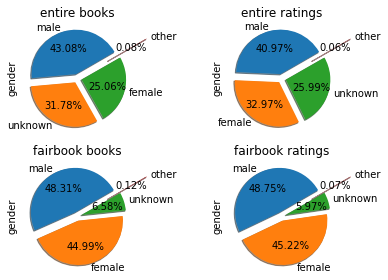

In [207]:
fig, axes = plt.subplots(nrows=2, ncols=2)
for i in range(len(dfs)):
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    dfs[i].gender.value_counts().plot(kind="pie",autopct='%.2f%%',explode=(0.1, 0.1, 0.1,0.8), shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)],
                                     colors=[colors[v] for v in df['gender'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
fig.tight_layout()
#fig.suptitle("Gender Distribution")
#fig.show()

In [208]:
def check_most_common(column):
    most_common_5=[]
    for df in dfs:
        most_common_5.append(set([x[0] for x in Counter(df[column]).most_common()[:5]]))
    return len(np.unique(most_common_5))==1

## Analyze country

In [209]:
check_most_common("country")

False

In [210]:
for df in dfs:
    df["country"] = df["country"].apply(lambda x: "unknown" if x=="" else x)

In [211]:
most_common_5 = [x[0] for x in Counter(fairbook_ratings.country).most_common()[:5]]

In [212]:
for df in dfs:
    df["country"][df.country.isin(most_common_5) == False] = "other"

/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [213]:
colors={'USA':'#1f77b4', 
        'UK':'#d62728',
       "Ireland":"#8c564b",
       "unknown":"#ff7f0e",
       "Canada":"#9467bd",
       "other":"#2ca02c"}

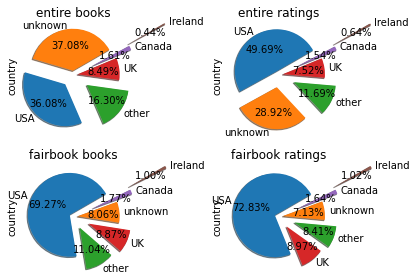

In [214]:
fig, axes = plt.subplots(nrows=2, ncols=2)
for i in range(len(dfs)):
    df = dfs[i].copy()
    df.country = df.country.replace("United States of America", "USA")
    df.country = df.country.replace("United Kingdom", "UK")
    df.country = df.country.replace("Republic of Ireland", "Ireland")
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    df.country.value_counts().plot(kind="pie",autopct='%.2f%%',explode=(0.1, 0.3, 0.4,0.1, 0.5,1.5), shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)], 
                                   colors=[colors[v] for v in df['country'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
    
fig.tight_layout()
#fig.suptitle("Gender Distribution")
fig.show()

## Analyze Language

In [215]:
for df in dfs:
    df["language"] = df["language"].apply(lambda x: "unknown" if x=="" else x)
    #df["gender"][(df.gender!="male") & (df.gender!="female") & (df.gender!="unknown")] = "other"

In [216]:
check_most_common("language")

False

In [217]:
most_common_5 = [x[0] for x in Counter(fairbook_ratings.country).most_common()[:5]]

/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

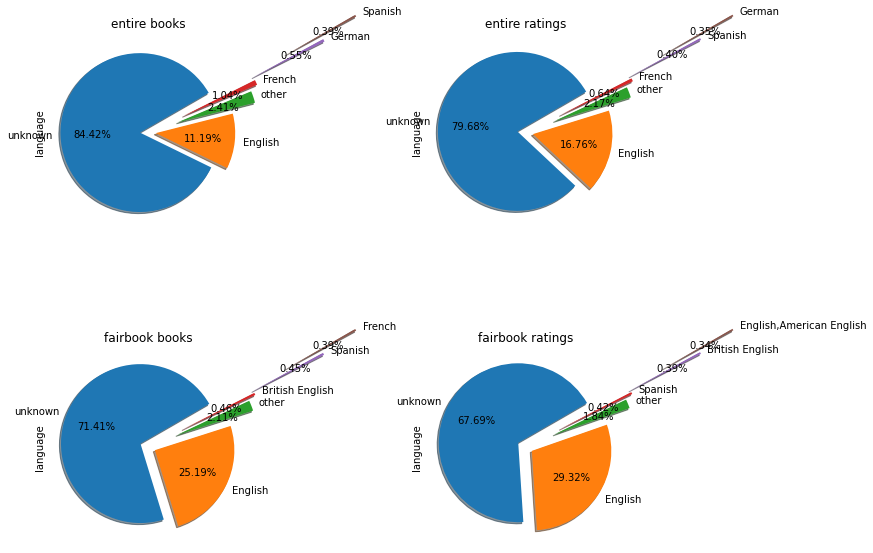

In [218]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
for i in range(len(dfs)):
    
    df = dfs[i].copy()
    most_common_5 = [x[0] for x in Counter(df.language).most_common()[:5]]
    df["language"][df.language.isin(most_common_5) == False] = "other"
    
    #df.country = df.country.replace("United States of America", "USA")
    #df.country = df.country.replace("United Kingdom", "UK")
    #df.country = df.country.replace("Republic of Ireland", "Ireland")
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    df.language.value_counts().plot(kind="pie",autopct='%.2f%%',explode=(0.1, 0.1, 0.4,0.5, 1.5,2), shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)])
    #, 
     #                              colors=[colors[v] for v in df['country'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)
#fig.tight_layout()
#fig.suptitle("Gender Distribution")
fig.show()

## Analyze birthyear

/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/export/scratch2/home/savvina/new_environment/lib64/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

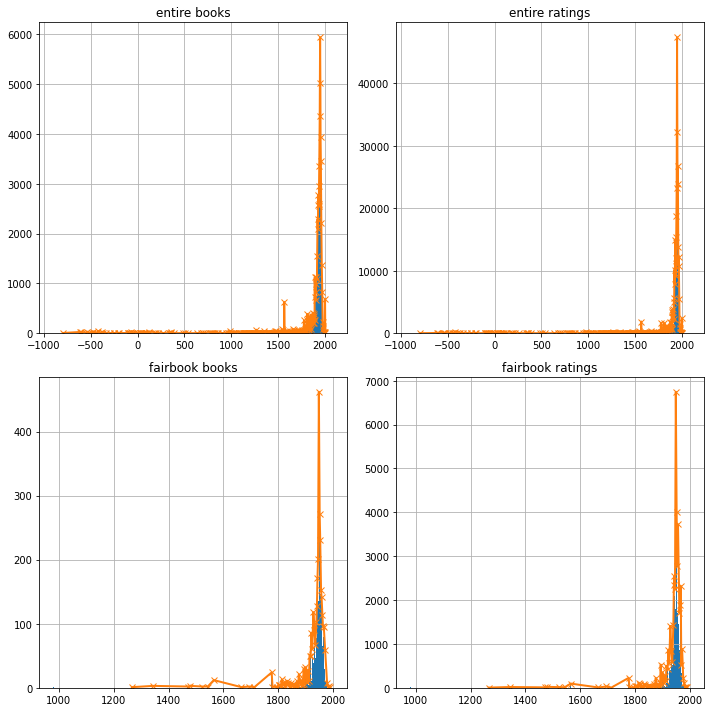

In [224]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
for i in range(len(dfs)):
    df = dfs[i].copy()
    c = df[df.birthyear!=""]
    c.birthyear = c.birthyear.astype("float")
    max_frequency = c['birthyear'].value_counts().max()
    #print(max_frequency)
#     print(c.birthyear.mode().iloc[0])
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    
    n = math.ceil((c.birthyear.max() - c.birthyear.min()))
#     print(n)
    c.hist(column="birthyear", bins=n,ax=axes[int(j1),int(j2)])
#     df.country.value_counts().plot(kind="pie",autopct='%.2f%%',explode=(0.1, 0.3, 0.4,0.1, 0.5,1.5), shadow=True
#                                       , startangle=30, ax=axes[int(j1),int(j2)], 
#                                    colors=[colors[v] for v in df['country'].value_counts().keys()])

    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
    
    
    hist, bin_edges = np.histogram(list(c.birthyear), int(max(c.birthyear)-min(c.birthyear)))
    bin_edges = bin_edges[1:]
    peaks, _ = find_peaks(hist)
    axes[int(j1),int(j2)].plot(bin_edges[peaks], hist[peaks],linewidth=2, marker ='x')
    
    #axes[int(j1),int(j2)].set_ylim(0,max_frequency)
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.9, 
#                     hspace=0.2)    
fig.tight_layout()
fig.show()

In [238]:
for df in dfs:
    df["birthyear_coded"] = df["birthyear"].apply(lambda x: "1000000" if x=="" else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "2000000" if int(x)<0 else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "3000000" if (int(x)>=0)&(int(x)<1900) else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "4000000" if (int(x)>=1900)&(int(x)<1950) else x)
    df["birthyear_coded"] = df["birthyear_coded"].apply(lambda x: "5000000" if (int(x)>=1950)&(int(x)<200000) else x)

In [239]:
for df in dfs:
    df.birthyear_coded = df.birthyear_coded.replace("1000000","unknown")
    df.birthyear_coded = df.birthyear_coded.replace("2000000","B.C.")
    df.birthyear_coded = df.birthyear_coded.replace("3000000","0-1900")
    df.birthyear_coded = df.birthyear_coded.replace("4000000","1900-1950")
    df.birthyear_coded = df.birthyear_coded.replace("5000000","1950-2000")

In [240]:
colors={'1900-1950':'#1f77b4', 
        '1950-2000':'#d62728',
       "unknown":"#2ca02c",
       "0-1900":"#ff7f0e",
       "B.C.":"black"}

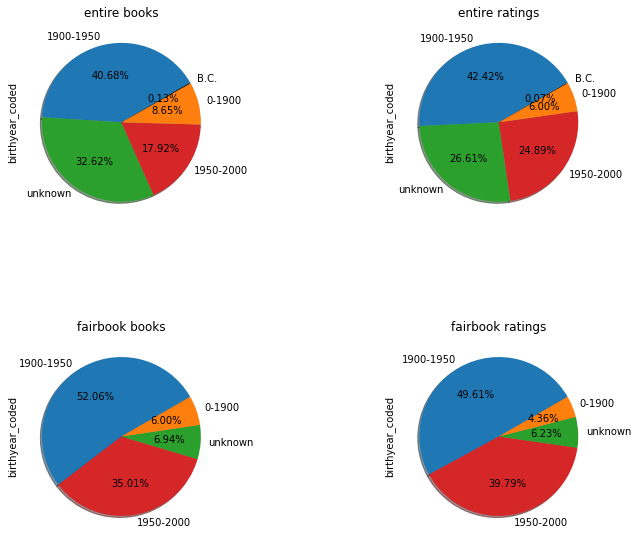

In [241]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
for i in range(len(dfs)):
    
    df = dfs[i].copy()
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    df.birthyear_coded.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)]
                                     ,colors=[colors[v] for v in df['birthyear_coded'].value_counts().keys()])
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)
#fig.tight_layout()
#fig.suptitle("Gender Distribution")
#fig.show()

In [242]:
for df in dfs:
    for index, row in df.iterrows():
        if (row.birthyear_coded == "1950-2000") | (row.birthyear_coded == "1900-1950"):
            year = row.birthyear
            year_rounded_down = math.floor(year/10)*10
            df.at[index, "birthyear_coded"] = str(year_rounded_down)+"s"

In [243]:
dfs[0].birthyear_coded.unique()

array(['unknown', '1930s', '1940s', '1950s', '1960s', '1970s', '0-1900',
       '1920s', '1900s', '1910s', '2000s', '1980s', '1990s', 'B.C.',
       '2080s'], dtype=object)

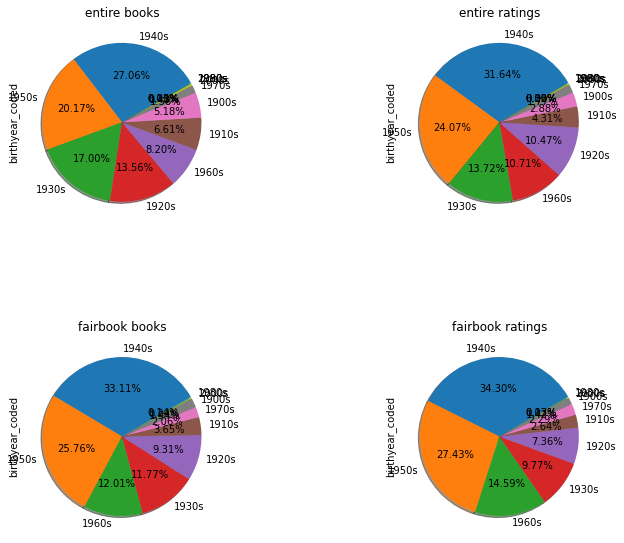

In [244]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
for i in range(len(dfs)):
    
    df = dfs[i].copy()
    df = df[(df.birthyear_coded!="unknown")&(df.birthyear_coded!="B.C.")&(df.birthyear_coded!="0-1900")]
    j1 = np.divide(i,2)
    j2 = np.mod(i,2)
    df.birthyear_coded.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30, ax=axes[int(j1),int(j2)]
                                     )
    axes[int(j1),int(j2)].tick_params(labelrotation=0)
    axes[int(j1),int(j2)].title.set_text(dfs_names[i])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.2)
#fig.tight_layout()
#fig.suptitle("Gender Distribution")
#fig.show()

In [245]:
dfs[0][dfs[0].birthyear_coded == "2000s"].birthyear.unique()

array([2000.0, 2002.0], dtype=object)